In [1]:
# import libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds

In [2]:
# Load IMDb dataset from tfds
(train_data, test_data), info = tfds.load(
    'imdb_reviews',
    split=['train', 'test'], 
    as_supervised=True,
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\ahmad\tensorflow_datasets\imdb_reviews\plain_text\incomplete.EVO2AW_1.0.0\imdb_reviews-trai…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\ahmad\tensorflow_datasets\imdb_reviews\plain_text\incomplete.EVO2AW_1.0.0\imdb_reviews-test…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\ahmad\tensorflow_datasets\imdb_reviews\plain_text\incomplete.EVO2AW_1.0.0\imdb_reviews-unsu…

Dataset imdb_reviews downloaded and prepared to C:\Users\ahmad\tensorflow_datasets\imdb_reviews\plain_text\1.0.0. Subsequent calls will reuse this data.


In [3]:
# Convert tf.data.Dataset to plain lists for tokenization
train_sentences = []
train_labels = []
for s, l in train_data:
    train_sentences.append(s.numpy().decode('utf-8'))
    train_labels.append(l.numpy())

test_sentences = []
test_labels = []
for s, l in test_data:
    test_sentences.append(s.numpy().decode('utf-8'))
    test_labels.append(l.numpy())

In [4]:
# Tokenize the text
vocab_size = 10000
maxlen = 200
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)

In [5]:
# Convert text to sequences
x_train = tokenizer.texts_to_sequences(train_sentences)
x_test = tokenizer.texts_to_sequences(test_sentences)

In [6]:
# Pad sequences
x_train = pad_sequences(x_train, maxlen=maxlen, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=maxlen, padding='post', truncating='post')

In [7]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [ ]:
# define model
model = models.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=64),
    layers.LSTM(64, dropout=0.3, recurrent_dropout=0.2),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Build the model to show summary
model.build(input_shape=(None, maxlen))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 673,089 (2.57 MB)

 Trainable params: 673,089 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=6,
    batch_size=64,
    validation_data=(x_test, y_test),
    callbacks=[early_stop]
)

Epoch 1/6
391/391 ━━━━━━━━━━━━━━━━━━━━ 116s 288ms/step - accuracy: 0.5177 - loss: 0.6915 - val_accuracy: 0.5402 - val_loss: 0.6961
Epoch 2/6
391/391 ━━━━━━━━━━━━━━━━━━━━ 110s 281ms/step - accuracy: 0.5602 - loss: 0.6752 - val_accuracy: 0.6317 - val_loss: 0.6196
Epoch 3/6
391/391 ━━━━━━━━━━━━━━━━━━━━ 111s 283ms/step - accuracy: 0.6428 - loss: 0.6076 - val_accuracy: 0.5592 - val_loss: 0.7250
Epoch 4/6
391/391 ━━━━━━━━━━━━━━━━━━━━ 102s 260ms/step - accuracy: 0.7474 - loss: 0.5298 - val_accuracy: 0.7850 - val_loss: 0.4933
Epoch 5/6
391/391 ━━━━━━━━━━━━━━━━━━━━ 95s 243ms/step - accuracy: 0.8138 - loss: 0.4466 - val_accuracy: 0.8018 - val_loss: 0.4765
Epoch 6/6
391/391 ━━━━━━━━━━━━━━━━━━━━ 105s 268ms/step - accuracy: 0.8564 - loss: 0.3686 - val_accuracy: 0.7982 - val_loss: 0.4824


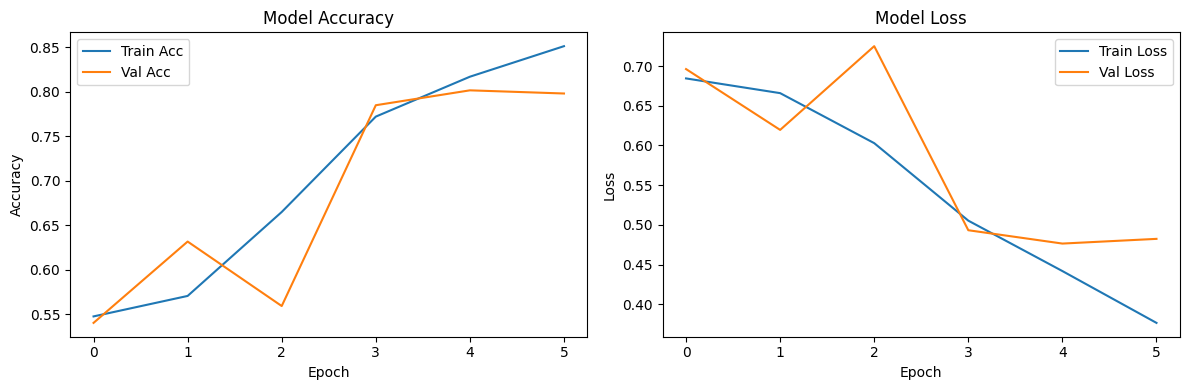

In [10]:
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
# Predict sentiment of sample reviews
sample_texts = [
    "This movie was absolutely wonderful! I loved it.",
    "Worst film I've ever seen. Complete waste of time."
]

sample_seq = tokenizer.texts_to_sequences(sample_texts)
sample_pad = pad_sequences(sample_seq, maxlen=maxlen, padding='post')

predictions = model.predict(sample_pad)

for i, pred in enumerate(predictions):
    sentiment = "Positive " if pred[0] > 0.5 else "Negative "
    print(f"\nReview: {sample_texts[i]}")
    print(f"Predicted Sentiment: {sentiment} ({pred[0]:.2f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

Review: This movie was absolutely wonderful! I loved it.
Predicted Sentiment: Positive  (0.81)

Review: Worst film I've ever seen. Complete waste of time.
Predicted Sentiment: Negative  (0.13)
